In [1]:
# 시작 전에 GPU로 바꿔주기

# CNN 모델 만들고, ImageDataGenerator을 이용해서 학습 진행하기

In [2]:
# 필요한 module import
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Google Drive 접근 = 구글 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ImageDataGenerator 만들기


> rescale만 사용



In [4]:
# 이미지들이 있는 train, validation 폴더 가져오기
# 이 이미지들은 본인의 Local 파일에 각각 저장되어 있어야한다
# FinalProject에 있는 infant라는 폴더를 본인의 드라이브에 넣기!

train_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/train'
validation_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/valid'

In [9]:
# ImageDataGenerator 객체 생성

train_datagen = ImageDataGenerator(rescale=1/255) # 0 or 1의 값이 나올 수 있도록 255로 나누어 준다
validation_datagen=ImageDataGenerator(rescale=1/255)


# ImageDataGenerator 객체 세부 설정
# 넌 이렇게 동작해야해! 라고 세부 세팅을 해준다

train_generator = train_datagen.flow_from_directory( # train_datagen.flow_from_directory() 특정 폴더로부터 generator을 뽑아내는 객체를 하나 만든다
    train_dir, # target directory
    classes=['positive', 'neutral', 'negative'], # train 안에 있는 폴더를 내가 원하는 순서대로 준다 (positive -> neutral -> negative)
                                                 # label(target) 지정, list의 순서대로 지정하기!
                                                 # 만약 생략되면 폴더 순서는 오름차순으로 지정된다.
    target_size=(150, 150), #image resize
    batch_size=5, # 한번에 20개의 이미지를 가져온다
                  # label에 상관없이 이미지를 가져온다
    class_mode='categorical' # 다중분류 : categorical, 이진분류 : binary
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150), # 평가 데이터이기 떄문에 size를 똑같이 가져와야 한다
    batch_size=5,
    class_mode='categorical'
)

Found 380 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


## CNN Model 구현

In [10]:
# 필터의 개수는 앞쪽에서 뒤쪽으로 갈 수록 많아지는 것이 좋다
# 필터의 크기(kernel_size)는 3x3 을 보통 쓴다

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))  # 여기서는 input_shape을 빼주어야한다
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.summary() # 중간에 확인해주고 넘어가기

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=3,
                activation='softmax'))

model.summary()


# Total params: 3600707 (13.74 MB)
# Trainable params: 3600707 (13.74 MB) -> 학습이 가능한, 값이 바뀌는 파라미터

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [13]:
# model 학습 설정


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# model checkpoint 확인
model_cp = ModelCheckpoint(filepath='infantface_checkpoint.ckpt', # 임시로 제공 받은 runtime disk에 파일이 만들어진다. 계산된 가중치를 저장해놓자
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

# model earlystopping 확인(조기 종료는 언제할까요?)
model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)


history = model.fit(train_generator,
                    steps_per_epoch=76,  # 1 epoch 당 몇 번 수행할지 정해주어야 한다. 이것도 직접 계산 380/5 = 76
                    epochs=100,
                    verbose=1,
                    #validation_split=0.3 이라고 썼었는데, 이제 validation_data가 따로 있기 때문에
                    validation_data=validation_generator,
                    validation_steps=12, # 계산해서 넣어주어야 한다
                                         # 즉, 60/5 = 12
                    callbacks=[model_cp, model_es])


model.save('./infantface_cnn_model.h5') # 학습이 끝나면, 우리 모델에 대해서 한 번에 딱 저장
# 저장하는 방법 2가지
# 1. checkpoint와 callback을 이용해서 epoch마다 저장해준다
# 2. 모델에 있어서 한 번에 저장


# 위 처럼 만들고 model 학습 진행 (shift+enter)

Epoch 1/100
74/76 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9568
Epoch 1: val_loss improved from inf to 0.54481, saving model to infantface_checkpoint.ckpt
76/76 [==============================] - 4s 34ms/step - loss: 0.1342 - accuracy: 0.9553 - val_loss: 0.5448 - val_accuracy: 0.8000
Epoch 2/100
75/76 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9547
Epoch 2: val_loss did not improve from 0.54481
76/76 [==============================] - 2s 30ms/step - loss: 0.1406 - accuracy: 0.9553 - val_loss: 0.7222 - val_accuracy: 0.8167
Epoch 3/100
75/76 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9840
Epoch 3: val_loss improved from 0.54481 to 0.53477, saving model to infantface_checkpoint.ckpt
76/76 [==============================] - 3s 36ms/step - loss: 0.0813 - accuracy: 0.9842 - val_loss: 0.5348 - val_accuracy: 0.8167
Epoch 4/100
75/76 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.97

In [ ]:
# 마지막 결과값
# loss: 0.0398 - accuracy: 0.9868 - val_loss: 0.3723 - val_accuracy: 0.9167

# 기준을 어떻게 세워야 하는가?
# 1. loss, val_loss
# 기준 : 손실은 모델이 실제 값과 예측 값 간의 차이를 나타내므로, "낮을수록 좋다"
# 해석 : 훈련 손실과 검증 손실이 둘 다 감소하는 것은, 모델이 데이터에 잘 적함되고 있다는 것을 나타낸다.
#       그러나, 두 손실이 크게 차이나는 경우에는 과적합이 발생할 가능성이 있으므로 주의가 필요
# 2. accuracy, val_accuracy
# 기준 : 모델이 올바르게 분류한 샘플의 비율을 나타내므로, "높을수록 좋다"
# 해석 : 훈련 정확도와 검증 정확도가 둘 다 증가하는 것은 모델이 데이터를 잘 이해하고 일반화되고 있다는 것을 나타냅니다.
#       과적합이 발생하지 않도록 주의해야 합니다.

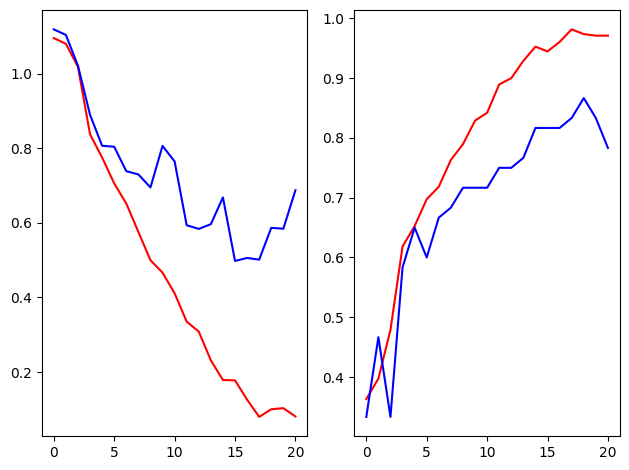

In [12]:
# 결과 그래프를 그려보아요!
# 이때, 그래프를 해석할 줄 알아야 한다.
# 기준 : loss(훈련 손실)과 val_loss(검증 손실) 차이가 크지 않고,
#       accarcy(훈련 정확도) val_accuracy(검증 정확도)가 유사한지 확인해봐야한다.
# 해석 : 이러한 관계가 유지되면 모델이 새로운 데이터에 대해 일반화할 수 있음을 나타내며, 과적합이 발생하지 않았음을 이야기함.
# 만약, val_loss의 선인 파란선이 중간에 상승하는 모습을 보인다면 = Overfitting --> 차이가 생기기 시작하기 때문!

import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

# training data가 잘 맞춰졌으니까 좋은 결과를 나타내지만
# ax1 파란선이 중간에 상승하는 모습을 보여 overfitting이 생겼다는 것을 알 수 있다

In [ ]:
# Early Stopping 및 Model Checkpoint 콜백 활용
# 어떻게?
# Early Stopping과 Model Checkpoint 콜백을 사용하여 검증 손실이 더 이상 감소하지 않거나 증가하기 시작할 때 학습을 조기 종료하고 최적의 모델을 저장합니다.
# 해석
# 이는 모델이 더 이상 개선되지 않고 있거나 과적합이 시작될 때 학습을 중단하여 일반화된 모델을 얻을 수 있도록 도와줍니다.

# Test 진행

In [14]:
# 테스트에 필요한 module import
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [25]:
# 저장된 모델 파일의 경로
saved_model_path = '/content/infantface_cnn_model.h5'

# 테스트할 이미지 경로 설정
test_image_path = '/content/drive/MyDrive/KOSA3/project/data/baby6.png'

# 모델 로드
loaded_model = load_model(saved_model_path)

# 이미지 불러오기 및 전처리
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [26]:
# 모델 예측
predictions = loaded_model.predict(img_array)

# 예측 결과 해석 및 출력
class_indices = np.argmax(predictions, axis=1)

# 각 클래스의 인덱스에 따른 레이블 설정 (positive, neutral, negative)
class_labels = ['positive', 'neutral', 'negative']
predicted_label = class_labels[class_indices[0]]

print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 0s 73ms/step
Predicted Class: negative
